In [1]:
!pip install pandas numpy scikit-learn underthesea scikit-surprise seaborn matplotlib 

Defaulting to user installation because normal site-packages is not writeable



[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import numpy as np

# Collaborative Filtering Libraries
from surprise import Dataset, Reader, SVD
from surprise.model_selection import train_test_split, cross_validate
from surprise import accuracy

# Content-Based Filtering Libraries
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
from sklearn.preprocessing import MinMaxScaler


# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns


In [3]:
user_item_path = '../data/user_item_interactions.csv'
product_content_path = '../data/product_contents.csv'
user_item_df = pd.read_csv(user_item_path)
product_content_df = pd.read_csv(product_content_path)

In [4]:
user_item_df.head()

,user_id,product_id,interaction_type,interaction_score
0,16b94b68-3876-4b2e-a983-57c491b9e3de,75e094a1-bd7c-4dd9-a8c9-e4e28ac625bb,purchase,5
1,16b94b68-3876-4b2e-a983-57c491b9e3de,d70d9dbd-eb54-4888-875f-4da384a5a0a5,purchase,5
2,16b94b68-3876-4b2e-a983-57c491b9e3de,ae4b4eee-886c-47fd-8bb2-6126dcb5f0ae,purchase,5
3,16b94b68-3876-4b2e-a983-57c491b9e3de,6116fdf3-473f-4324-af54-1b950076ef52,purchase,5
4,49b80737-8f0a-463b-9a8b-c0f820ed5973,e9fcdf70-27d5-4da8-b082-3e3cfb515ba7,purchase,5


In [5]:
product_content_df.head()

,productid,productname,categoryname,farmname,farmprovince
0,6116fdf3-473f-4324-af54-1b950076ef52,Xoài Cát,Trái cây,Trang trại trái cây,Quảng Nam
1,e24af3cd-fc9f-400c-8c76-8aba05a803b5,Cải Bẹ Xanh,Rau lá,Rau Hữu Cơ,Lâm Đồng
2,b7237f07-c2bf-48d7-a630-3faaac02cfcc,Gạo ST25,Lương thực,Gạo sạch,Đồng Tháp
3,95827b65-ec7b-405b-bd26-6558d04211cf,Gạo nếp,Lương thực,Gạo sạch,Đồng Tháp
4,aaa373ef-1cfe-4e6a-9c87-eeba7eaec713,Mãng Cầu Xiêm,Trái cây,Ngũ sắc,Dak Lak


In [8]:
user_item_df.shape

(1005, 4)

In [10]:
product_content_df.shape

(200, 5)

In [11]:
user_item_df.describe()

,interaction_score
count,1005.000000
mean,4.236816
std,0.980709
min,1.000000
25%,3.000000
50%,5.000000
75%,5.000000
max,5.000000


In [12]:
product_content_df.describe()

,productid,productname,categoryname,farmname,farmprovince
count,200,200,200,200,200
unique,200,113,8,22,12
top,6116fdf3-473f-4324-af54-1b950076ef52,Rau mồng tơi,Rau lá,Trang Trại Xanh,Dak Lak
freq,1,6,58,21,73


In [13]:
user_item_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1005 entries, 0 to 1004
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1005 non-null   object
 1   product_id         1005 non-null   object
 2   interaction_type   1005 non-null   object
 3   interaction_score  1005 non-null   int64 
dtypes: int64(1), object(3)
memory usage: 31.5+ KB


In [4]:
product_content_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   productid     200 non-null    object
 1   productname   200 non-null    object
 2   categoryname  200 non-null    object
 3   farmname      200 non-null    object
 4   farmprovince  200 non-null    object
dtypes: object(5)
memory usage: 7.9+ KB


In [10]:
print(user_item_df['interaction_score'].unique())

[5 3 4 1 2]


In [11]:
# Loại bỏ các bản ghi có interaction_score không nằm trong khoảng 0-5
user_item_df = user_item_df[user_item_df['interaction_score'].between(1, 5)]
# Kiểm tra lại các giá trị của interaction_score
print(user_item_df['interaction_score'].unique())

[5 3 4 1 2]


In [13]:
num_users = user_item_df['user_id'].nunique()
num_users

50

In [14]:
num_products = product_content_df['productid'].nunique()
num_products

200

In [15]:
interaction_types = user_item_df['interaction_type'].value_counts()
print("\nPhân bố các loại tương tác:")
print(interaction_types)


Phân bố các loại tương tác:
interaction_type
purchase       463
add_to_cart    338
review         204
Name: count, dtype: int64


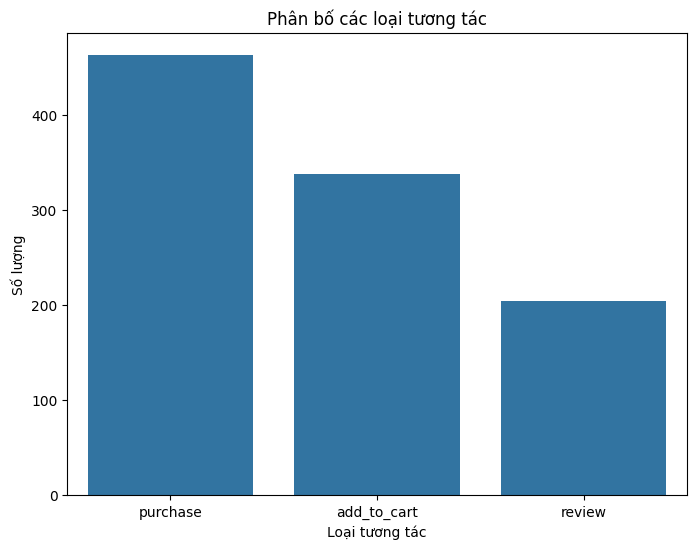

In [16]:
plt.figure(figsize=(8,6))
sns.countplot(x='interaction_type', data=user_item_df)
plt.title('Phân bố các loại tương tác')
plt.xlabel('Loại tương tác')
plt.ylabel('Số lượng')
plt.show()

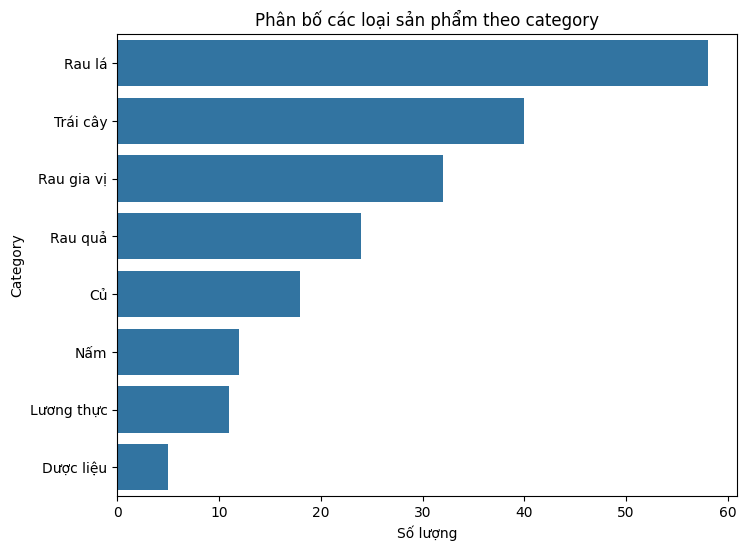

In [17]:
# biểu đồ phân loại sản phẩm theo category
plt.figure(figsize=(8,6))
sns.countplot(y='categoryname', data=product_content_df, order = product_content_df['categoryname'].value_counts().index)
plt.title('Phân bố các loại sản phẩm theo category')
plt.xlabel('Số lượng')
plt.ylabel('Category')
plt.show()

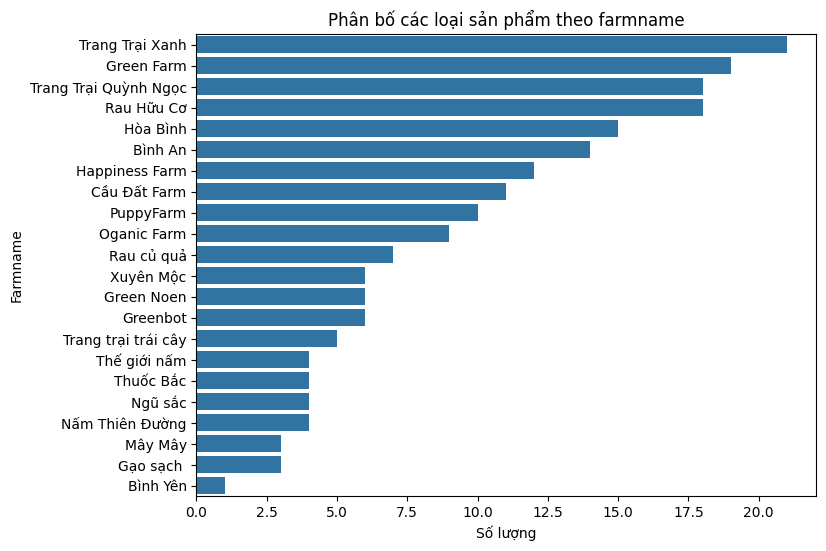

In [18]:
# biểu đồ phân loại sản phẩm theo farmname
plt.figure(figsize=(8,6))
sns.countplot(y='farmname', data=product_content_df, order = product_content_df['farmname'].value_counts().index)
plt.title('Phân bố các loại sản phẩm theo farmname')
plt.xlabel('Số lượng')
plt.ylabel('Farmname')
plt.show()


Xây dựng model

In [ ]:
reader = Reader(rating_scale=(1, 5))

In [21]:
data = Dataset.load_from_df(user_item_df[['user_id', 'product_id', 'interaction_score']], reader)
data

In [22]:
trainset, testset = train_test_split(data, test_size=0.2, random_state=42)

In [23]:
svd_model = SVD()

In [24]:
svd_model.fit(trainset)

In [25]:
predictions = svd_model.test(testset)


In [26]:
rmse = accuracy.rmse(predictions)
mae = accuracy.mae(predictions)

RMSE: 0.8733
MAE:  0.7511


In [12]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

# Perform Grid Search
gs = GridSearchCV(SVD, param_grid, measures=['rmse', 'mae'], cv=5)
gs.fit(data)

# Get the best parameters
best_params = gs.best_params['rmse']
print("Best parameters: ", best_params)

# Initialize the SVD model with best parameters
svd_model = SVD(n_factors=best_params['n_factors'], n_epochs=best_params['n_epochs'],
                lr_all=best_params['lr_all'], reg_all=best_params['reg_all'])

# Train the model
svd_model.fit(trainset)

Best parameters:  {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05}


In [10]:
import pandas as pd
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import GridSearchCV, cross_validate
import pickle

# Đọc dữ liệu từ tệp CSV
df = pd.read_csv('../data/user_item_interactions.csv')

# Chỉ giữ lại các cột cần thiết
df = df[['user_id', 'product_id', 'interaction_score']]

# Định nghĩa Reader và tải dữ liệu từ DataFrame
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'product_id', 'interaction_score']], reader)

# Định nghĩa lưới tham số cho SVD
param_grid_svd = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

# Thực hiện Grid Search cho SVD
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=5)
gs_svd.fit(data)

# Lấy các tham số tốt nhất cho SVD
best_params_svd = gs_svd.best_params['rmse']
print("Best parameters for SVD: ", best_params_svd)

# Khởi tạo mô hình SVD với các tham số tốt nhất
svd_model = SVD(n_factors=best_params_svd['n_factors'], n_epochs=best_params_svd['n_epochs'],
                lr_all=best_params_svd['lr_all'], reg_all=best_params_svd['reg_all'])

# Đánh giá mô hình SVD bằng cross-validation
cv_results_svd = cross_validate(svd_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Định nghĩa lưới tham số cho KNNBasic
param_grid_knn = {
    'k': [20, 40, 60],
    'sim_options': {
        'name': ['msd', 'cosine', 'pearson'],
        'user_based': [False]
    }
}

# Thực hiện Grid Search cho KNNBasic
gs_knn = GridSearchCV(KNNBasic, param_grid_knn, measures=['rmse', 'mae'], cv=5)
gs_knn.fit(data)

# Lấy các tham số tốt nhất cho KNNBasic
best_params_knn = gs_knn.best_params['rmse']
print("Best parameters for KNNBasic: ", best_params_knn)

# Khởi tạo mô hình KNNBasic với các tham số tốt nhất
knn_model = KNNBasic(k=best_params_knn['k'], sim_options=best_params_knn['sim_options'])

# Đánh giá mô hình KNNBasic bằng cross-validation
cv_results_knn = cross_validate(knn_model, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

# Lưu mô hình SVD
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)

# Lưu mô hình KNNBasic
with open('knn_model.pkl', 'wb') as f:
    pickle.dump(knn_model, f)

Best parameters for SVD:  {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.05}
Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9046  0.8451  0.9257  0.9145  0.8304  0.8841  0.0387  
MAE (testset)     0.7653  0.7282  0.7770  0.7646  0.7370  0.7544  0.0186  
Fit time          0.00    0.00    0.01    0.00    0.00    0.00    0.00    
Test time         0.00    0.00    0.00    0.00    0.00    0.00    0.00    
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the msd similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matr

In [4]:
# Đọc dữ liệu từ tệp CSV
df = pd.read_csv('../data/user_item_interactions.csv')

# Chỉ giữ lại các cột cần thiết
df = df[['user_id', 'product_id', 'interaction_score']]


In [5]:
# Định nghĩa Reader và tải dữ liệu từ DataFrame
reader = Reader(rating_scale=(1, 5))
data = Dataset.load_from_df(df[['user_id', 'product_id', 'interaction_score']], reader)

In [6]:
# Định nghĩa lưới tham số cho SVD
param_grid_svd = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30, 40],
    'lr_all': [0.002, 0.005, 0.01],
    'reg_all': [0.02, 0.05, 0.1]
}

In [ ]:
import pandas as pd
from surprise import Dataset, Reader, SVD, KNNBasic
from surprise.model_selection import GridSearchCV, cross_validate
import pickle
# Thực hiện Grid Search cho SVD
gs_svd = GridSearchCV(SVD, param_grid_svd, measures=['rmse', 'mae'], cv=5)
gs_svd.fit(data)

In [9]:
# Lấy các tham số tốt nhất cho SVD
best_params_svd = gs_svd.best_params['rmse']
print("Best parameters for SVD: ", best_params_svd)

Best parameters for SVD:  {'n_factors': 50, 'n_epochs': 20, 'lr_all': 0.005, 'reg_all': 0.1}


In [10]:
svd_model = SVD(n_factors=best_params_svd['n_factors'], 
                n_epochs=best_params_svd['n_epochs'],
                lr_all=best_params_svd['lr_all'], 
                reg_all=best_params_svd['reg_all'])

In [13]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import linear_kernel
import pickle

# Giả sử bạn đã có DataFrame 'product_content_df' chứa dữ liệu sản phẩm
product_content_df['content'] = (
    product_content_df['productname'] + ' ' +
    product_content_df['categoryname'] + ' ' + 
    product_content_df['farmname'] + ' ' + 
    product_content_df['farmprovince']
)

# Tiền xử lý dữ liệu văn bản
product_content_df['content'] = product_content_df['content'].str.lower().str.replace('[^\w\s]', '')

# Tối ưu hóa TfidfVectorizer
tfidf = TfidfVectorizer(max_features=10000, ngram_range=(1, 2), stop_words='english')
tfidf_matrix = tfidf.fit_transform(product_content_df['content'])
print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")

# Tính cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Tạo Series mapping productid tới chỉ số trong DataFrame
indices = pd.Series(product_content_df.index, index=product_content_df['productid']).drop_duplicates()

# Lưu TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Lưu cosine similarity matrix
with open('cosine_similarity.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)

TF-IDF Matrix shape: (200, 559)


In [11]:
product_content_df['content'] = (
                                product_content_df['productname'] + ' ' +
                                product_content_df['categoryname'] + ' ' + 
                                product_content_df['farmname'] + ' ' + 
                                product_content_df['farmprovince'])
product_content_df.head()

,productid,productname,categoryname,farmname,farmprovince,content
0,6116fdf3-473f-4324-af54-1b950076ef52,Xoài Cát,Trái cây,Trang trại trái cây,Quảng Nam,Xoài Cát Trái cây Trang trại trái cây Quảng Nam
1,e24af3cd-fc9f-400c-8c76-8aba05a803b5,Cải Bẹ Xanh,Rau lá,Rau Hữu Cơ,Lâm Đồng,Cải Bẹ Xanh Rau lá Rau Hữu Cơ Lâm Đồng
2,b7237f07-c2bf-48d7-a630-3faaac02cfcc,Gạo ST25,Lương thực,Gạo sạch,Đồng Tháp,Gạo ST25 Lương thực Gạo sạch Đồng Tháp
3,95827b65-ec7b-405b-bd26-6558d04211cf,Gạo nếp,Lương thực,Gạo sạch,Đồng Tháp,Gạo nếp Lương thực Gạo sạch Đồng Tháp
4,aaa373ef-1cfe-4e6a-9c87-eeba7eaec713,Mãng Cầu Xiêm,Trái cây,Ngũ sắc,Dak Lak,Mãng Cầu Xiêm Trái cây Ngũ sắc Dak Lak


In [28]:
tfidf = TfidfVectorizer(max_features=5000, ngram_range=(1,2))

In [29]:
tfidf_matrix = tfidf.fit_transform(product_content_df['content'])
print(f"TF-IDF Matrix shape: {tfidf_matrix.shape}")

TF-IDF Matrix shape: (200, 561)


In [31]:
# Tính cosine similarity
cosine_sim = linear_kernel(tfidf_matrix, tfidf_matrix)

# Tạo Series mapping productid tới chỉ số trong DataFrame
indices = pd.Series(product_content_df.index, index=product_content_df['productid']).drop_duplicates()


In [32]:
def get_content_based_recommendations(productid, cosine_sim=cosine_sim, indices=indices, product_content_df=product_content_df, top_n=10):
    if productid not in indices:
        return []
    
    idx = indices[productid]
    
    # Lấy cosine similarity của sản phẩm với tất cả các sản phẩm khác
    sim_scores = list(enumerate(cosine_sim[idx]))
    
    # Sắp xếp các sản phẩm dựa trên similarity score
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    
    # Lấy top_n sản phẩm tương tự (bỏ qua sản phẩm đầu tiên vì đó là chính nó)
    sim_scores = sim_scores[1:top_n+1]
    
    # Lấy chỉ số của các sản phẩm
    product_indices = [i[0] for i in sim_scores]
    
    # Trả về danh sách productid và productname của các sản phẩm tương tự
    return product_content_df[['productname', 'categoryname', 'farmname', 'farmprovince']].iloc[product_indices].to_dict('records')

In [33]:
get_content_based_recommendations('6116fdf3-473f-4324-af54-1b950076ef52')

[{'productname': 'Xoài Keo',
  'categoryname': 'Trái cây',
  'farmname': 'Trang trại trái cây',
  'farmprovince': 'Quảng Nam'},
 {'productname': 'Ổi Hồng',
  'categoryname': 'Trái cây',
  'farmname': 'Trang trại trái cây',
  'farmprovince': 'Quảng Nam'},
 {'productname': 'Chuối Tiêu',
  'categoryname': 'Trái cây',
  'farmname': 'Trang trại trái cây',
  'farmprovince': 'Quảng Nam'},
 {'productname': 'Mãng Cầu Xiêm',
  'categoryname': 'Trái cây',
  'farmname': 'Trang trại trái cây',
  'farmprovince': 'Quảng Nam'},
 {'productname': 'Cam Sành',
  'categoryname': 'Trái cây',
  'farmname': 'Trang Trại Xanh',
  'farmprovince': 'Dak Lak'},
 {'productname': 'Mít thái',
  'categoryname': 'Trái cây',
  'farmname': 'Trang Trại Quỳnh Ngọc',
  'farmprovince': 'Dak Lak'},
 {'productname': 'Bơ sáp',
  'categoryname': 'Trái cây',
  'farmname': 'Trang Trại Quỳnh Ngọc',
  'farmprovince': 'Dak Lak'},
 {'productname': 'Bơ Booth',
  'categoryname': 'Trái cây',
  'farmname': 'Trang Trại Quỳnh Ngọc',
  'farmp

In [34]:
import pickle

# Lưu mô hình SVD
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)

# Lưu TF-IDF Vectorizer
with open('tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf, f)

# Lưu cosine similarity matrix
with open('cosine_similarity.pkl', 'wb') as f:
    pickle.dump(cosine_sim, f)


In [7]:
import pickle

# Lưu mô hình SVD
with open('svd_model.pkl', 'wb') as f:
    pickle.dump(svd_model, f)

In [5]:
# Lấy top 25 user có điểm tương tác cao nhất
user_interactions = user_item_df.groupby('user_id')['interaction_score'].sum()
top_25_user = user_interactions.sort_values(ascending=False).head(15)
print(top_25_user)

user_id
482d17f2-55f2-44dd-a97d-7924b2dd9859    188
013ee78c-20e1-4ca6-aa1e-d2ae19b84442    169
e9088ef5-a4f0-47a2-b53e-1020383f2b09    167
16b94b68-3876-4b2e-a983-57c491b9e3de    164
7ac59731-821d-4b78-8581-6466f7599bbe    145
15c1a68f-154c-43bb-ba87-21b4f50ef3f6    145
e28ce424-6cc8-4371-ba90-28dba9a65f34    131
74fd76af-31b9-4741-bd1c-d5be331ee077    124
bcde89b9-7107-4447-b31a-09088ae73636    123
d9deacc1-7a23-4368-b614-0fb3c1a38d1c    123
31b9001c-75ef-4c85-92df-e8dfed4f6309    122
6f7c368c-0c1a-42a5-84e8-7fd8505cd344    120
ec573c84-1b84-4b78-bc10-937c4ccf6702    107
6cf9592d-97a3-4a8b-8a1f-d7805e519c67    104
46973dfb-2b80-474c-9889-5294f94b795d    100
Name: interaction_score, dtype: int64


In [14]:
import json

def get_user_products_json(user_id, user_item_df, product_content_df):
    # Lọc danh sách product_id từ user_item_df dựa vào user_id
    user_products = user_item_df[user_item_df['user_id'] == user_id]['product_id'].unique()
    
    # Lọc thông tin chi tiết của các sản phẩm từ product_content_df
    product_indices = product_content_df[product_content_df['productid'].isin(user_products)].index
    
    # Chuyển kết quả thành JSON
    result = product_content_df[['productname', 'categoryname', 'farmname', 'farmprovince']].iloc[product_indices]
    return json.dumps(result.to_dict('records'), ensure_ascii=False, indent=4)

In [18]:
print(get_user_products_json('482d17f2-55f2-44dd-a97d-7924b2dd9859', user_item_df, product_content_df))
result_json = get_user_products_json('482d17f2-55f2-44dd-a97d-7924b2dd9859', user_item_df, product_content_df);
output_file = 'user_products.json'
with open(output_file, 'w', encoding='utf-8') as file:
    file.write(result_json)

[
    {
        "productname": "Gạo ST25",
        "categoryname": "Lương thực",
        "farmname": "Gạo sạch ",
        "farmprovince": "Đồng Tháp"
    },
    {
        "productname": "Mãng Cầu Xiêm",
        "categoryname": "Trái cây",
        "farmname": "Ngũ sắc",
        "farmprovince": "Dak Lak"
    },
    {
        "productname": "Xoài Keo",
        "categoryname": "Trái cây",
        "farmname": "Ngũ sắc",
        "farmprovince": "Dak Lak"
    },
    {
        "productname": "Cam Sành",
        "categoryname": "Trái cây",
        "farmname": "Trang Trại Xanh",
        "farmprovince": "Dak Lak"
    },
    {
        "productname": "Nho Mỹ",
        "categoryname": "Trái cây",
        "farmname": "Ngũ sắc",
        "farmprovince": "Dak Lak"
    },
    {
        "productname": "Gừng",
        "categoryname": "Củ",
        "farmname": "Cầu Đất Farm",
        "farmprovince": "Lâm Đồng"
    },
    {
        "productname": "Chanh không hạt",
        "categoryname": "Trái cây",
       

In [6]:
# Lấy top 25 user có điểm tương tác cao nhất
user_interactions = user_item_df.groupby('user_id')['interaction_score'].sum()
top_25_user = user_interactions.sort_values(ascending=True).head(15)
print(top_25_user)

user_id
f52e9e4e-33d1-4f86-819b-d9e52ff8cc77    23
67c766e2-a051-4554-aa1d-da7e1f63d415    28
7e27c60c-fa8c-476f-a0f1-caf40f44b739    29
7b973387-da99-4387-ad97-dc028b447ab5    44
34a3554b-d552-4a82-bc40-afecebdf904e    45
8f58f0c0-ae6c-4db8-b7a5-01263659b22f    47
3d520dee-6f76-4948-ac58-855ca44494e4    48
ba95d332-7fc5-4272-9659-0e61f218d0b7    49
a98adab9-72f4-4a3d-a7f5-5f330d5bab3c    50
4ce64499-e5fb-483e-b5d4-1ee83dacd87b    51
678c31c4-66f7-4060-b52c-44cd42084114    52
b6d9c6af-51d5-4375-a75b-b6d84eedd1dd    53
49cda69a-26d0-4d3e-a7cf-49ed918db804    56
90b24745-f642-4947-af12-0999a7d985d1    59
0d22b583-2791-4166-aef4-d0573f42572a    63
Name: interaction_score, dtype: int64
